In [1]:
# cell 1

import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# 1. Load count matrix using TPM
data_path = '/Users/esrataner/Documents/DATA1030/count_matrix_120'
file_list = [f for f in os.listdir(data_path) if f.endswith('.tsv')]

def read_tpm_file(filename):
    df = pd.read_csv(os.path.join(data_path, filename), sep='\t',
                     usecols=['gene_id', 'TPM'])
    df = df.set_index('gene_id')
    sample_id = filename.replace('.tsv', '')
    df.columns = [sample_id]
    return df

dfs = [read_tpm_file(f) for f in file_list]
merged = pd.concat(dfs, axis=1)  # genes × samples
print("Raw merged shape:", merged.shape)

# 2. remove all spike-in genes 
# these are technical control genes - not needed for ML 
spikein_mask = merged.index.str.lower().str.contains(
    "spikein|ercc"
)

print("Spike-in genes detected:", spikein_mask.sum())

merged = merged.loc[~spikein_mask]
print("After removing spike-ins:", merged.shape)

# 3. Remove all-zero genes
zero_across_all = (merged == 0).all(axis=1)
print("Genes zero everywhere:", zero_across_all.sum())

expr = merged[~zero_across_all]
print("After removing all-zero genes:", expr.shape)

# 4. log1p(TPM) transform — biological normalization
expr_log = np.log1p(expr)

# NOTE: try graphing log1p and log 
# depends on if data is close to zero or not 

Raw merged shape: (59526, 120)
Spike-in genes detected: 97
After removing spike-ins: (59429, 120)
Genes zero everywhere: 14289
After removing all-zero genes: (45140, 120)


In [2]:
# cell 2

meta = pd.read_csv(
    '/Users/esrataner/Documents/DATA1030/tsv/experiment_report_2025_120.tsv',
    sep='\t', skiprows=1
)

# extract sex
meta['Sex'] = meta['Biosample summary'].str.extract(r'(?i)\b(female|male)\b')
meta['Sex'] = meta['Sex'].str.lower()

# parse numeric age
def parse_age(a):
    if pd.isna(a):
        return None
    nums = re.findall(r'\d+', str(a))
    return int(nums[0]) if nums else None

meta['Age'] = meta['Biosample age'].apply(parse_age)

# Age bins
def age_bin(x):
    if pd.isna(x): return None
    if x < 65: return "60-64"
    if x < 70: return "65-69"
    if x < 75: return "70-74"
    if x < 80: return "75-79"
    if x < 85: return "80-84"
    if x < 90: return "85-89"
    return "90+"

meta['Age_Ordinal'] = meta['Age'].apply(age_bin)

age_order = ["60-64","65-69","70-74","75-79","80-84","85-89","90+"]
meta['Age_Ordinal'] = pd.Categorical(
    meta['Age_Ordinal'], categories=age_order, ordered=True
)

# FIX!!  Extract *all* ENCFF file IDs (not just first)
# Find ALL ENCFF IDs
meta['File_IDs'] = meta['Files'].str.findall(r'ENCFF\w+')

# Expand metadata so each row contains ONE ENCFF ID
meta_expanded = meta.explode('File_IDs')

# Keep only relevant fields
meta_expanded = meta_expanded[
    ['Accession', 'Sex', 'Age_Ordinal', 'Biosample accession', 'File_IDs']
]

# Drop rows missing file IDs
meta_expanded = meta_expanded.dropna(subset=['File_IDs'])

print("Expanded metadata shape:", meta_expanded.shape)
# Expanded metadata shape: (1220, 5)

# exp 
# in the raw ENCODE metadata, each biological sample (ENCSR) has multiple ENCFF files 
# (technical sequencing files: BAMs, fastqs, quantifications, etc)

# After expanding, u get 1 row per ENCFF file
# so if each ENCSR has ~10 ENCFF files ->  120 biological samples become ~1220 rows.
# so 1220 is NOT 120 samples - it is technical files, NOT samples

# MOST IMPORTANTLY - do NOT need GroupShuffleSplit
# 1. each ENCSR is represented only once
# 2. no ENCFF technical replicates remain#
# 3. df_full has 1 row per biological sample





Expanded metadata shape: (1220, 5)


In [3]:
# cell 3 

# List of ENCFF IDs found in expression matrix
expr_samples = expr_log.columns.tolist()

# Match metadata rows where File_IDs map to expression samples
meta_matched = meta_expanded[meta_expanded['File_IDs'].isin(expr_samples)].copy()
print("Matched metadata rows:", meta_matched.shape)

# Step 1: Relabel expression matrix columns (ENCFF → ENCSR)
rename_dict = dict(zip(meta_matched['File_IDs'], meta_matched['Accession']))
expr_labeled = expr_log.rename(columns=rename_dict)

# Step 2: Identify replicate sample IDs (appear twice)
replicate_accessions = expr_labeled.columns[
    expr_labeled.columns.duplicated()
].unique()

print("Replicate sample accessions:", replicate_accessions.tolist())

# Step 3: DROP the replicate sample completely
expr_no_reps = expr_labeled.drop(columns=list(replicate_accessions))
meta_no_reps = meta_matched[
    ~meta_matched['Accession'].isin(replicate_accessions)
].copy()

print("Expression shape after removing replicates:", expr_no_reps.shape)
print("Metadata shape after removing replicates:", meta_no_reps.shape)

# Step 4: Align expression with metadata
expr_T = expr_no_reps.T
expr_T.index.name = 'Accession'
expr_T = expr_T.reset_index()

# Deduplicate final metadata
meta_unique = meta_no_reps.drop_duplicates(subset=['Accession'])

# Step 5: Merge into final ML-ready dataset
df_full = expr_T.merge(
    meta_unique.drop(columns=['File_IDs']),
    on='Accession',
    how='inner'
).set_index('Accession')

print("Final merged dataset shape:", df_full.shape)
print(df_full.head())
# cell 4 

# TRAIN / VAL / TEST SPLIT
from sklearn.model_selection import train_test_split

# (1) Define features + target
X = df_full.drop(columns=["Sex", "Biosample accession"]) #string carried over 
y = df_full["Sex"].map({"female": 0, "male": 1}).astype(int)

y = y.astype(int)

# (2) First split: Train vs Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# (3) Split Temp into Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Print shapes
print("Dataset Splits:")
print("Train:", X_train.shape, "Target:", y_train.shape)
print("Val:  ", X_val.shape,   "Target:", y_val.shape)
print("Test: ", X_test.shape,  "Target:", y_test.shape)


Matched metadata rows: (120, 5)
Replicate sample accessions: []
Expression shape after removing replicates: (45140, 120)
Metadata shape after removing replicates: (120, 5)
Final merged dataset shape: (120, 45143)
             13023     26893  30031  30958     30964  ENSG00000000003.14  \
Accession                                                                  
ENCSR800PJQ    0.0  0.506818    0.0    0.0  0.000000            1.348073   
ENCSR133PLR    0.0  0.000000    0.0    0.0  2.324347            1.340250   
ENCSR418WMG    0.0  0.000000    0.0    0.0  0.000000            1.181727   
ENCSR013HWB    0.0  0.438255    0.0    0.0  0.000000            1.313724   
ENCSR693KOP    0.0  0.000000    0.0    0.0  0.000000            1.081805   

             ENSG00000000005.5  ENSG00000000419.12  ENSG00000000457.13  \
Accession                                                                
ENCSR800PJQ           0.000000            2.157559            1.444563   
ENCSR133PLR           0.122218  

In [4]:
# cell 4 

# TRAIN / VAL / TEST SPLIT
from sklearn.model_selection import train_test_split

# (1) Define features + target
X = df_full.drop(columns=["Sex", "Biosample accession"]) #string carried over 
y = df_full["Sex"].map({"female": 0, "male": 1}).astype(int)

y = y.astype(int)

# (2) First split: Train vs Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# (3) Split Temp into Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Print shapes
print("Dataset Splits:")
print("Train:", X_train.shape, "Target:", y_train.shape)
print("Val:  ", X_val.shape,   "Target:", y_val.shape)
print("Test: ", X_test.shape,  "Target:", y_test.shape)


Dataset Splits:
Train: (84, 45141) Target: (84,)
Val:   (18, 45141) Target: (18,)
Test:  (18, 45141) Target: (18,)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import average_precision_score, classification_report

# preprocess 
gene_cols = [c for c in X_train.columns if c != "Age_Ordinal"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), gene_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["Age_Ordinal"])
])

# class weights 
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
class_weight = {0: 1.0, 1: neg / pos}

# actual pipeline 
def make_rf_pipeline():
    return Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            class_weight=class_weight,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        ))
    ])

# hyperparameter searching 
param_dist_rf = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": randint(3, 20),
    "model__max_features": uniform(0.05, 0.95),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
}

rf_search = RandomizedSearchCV(
    estimator=make_rf_pipeline(),
    param_distributions=param_dist_rf,
    n_iter=40,
    scoring="average_precision",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rf_search.fit(X_train, y_train)

print("\nBest CV PR-AUC:", rf_search.best_score_)
print("\nBest Params:", rf_search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END model__max_depth=13, model__max_features=0.48628644736757376, model__min_samples_leaf=5, model__min_samples_split=5, model__n_estimators=330; total time=  26.0s
[CV] END model__max_depth=13, model__max_features=0.48628644736757376, model__min_samples_leaf=5, model__min_samples_split=5, model__n_estimators=330; total time=  26.5s
[CV] END model__max_depth=13, model__max_features=0.48628644736757376, model__min_samples_leaf=5, model__min_samples_split=5, model__n_estimators=330; total time=  26.5s
[CV] END model__max_depth=13, model__max_features=0.48628644736757376, model__min_samples_leaf=5, model__min_samples_split=5, model__n_estimators=330; total time=  27.3s
[CV] END model__max_depth=13, model__max_features=0.48628644736757376, model__min_samples_leaf=5, model__min_samples_split=5, model__n_estimators=330; total time=  27.4s
[CV] END model__max_depth=9, model__max_features=0.8067158375172212, model__min_samples_

In [ ]:


best_rf_pipe = rf_search.best_estimator_

print("\nBest CV PR-AUC (RF RSCV):", rf_search.best_score_)
print("\nBest Hyperparameters:")
for k, v in rf_search.best_params_.items():
    print(f"{k}: {v}")

# validation performance
val_probs = best_rf_pipe.predict_proba(X_val)[:, 1]
print("\nVALIDATION PR-AUC:", average_precision_score(y_val, val_probs))

val_pred = best_rf_pipe.predict(X_val)
print("\nClassification Report:\n", classification_report(y_val, val_pred))



Best CV PR-AUC (RF RSCV): 0.8525

Best Hyperparameters:
model__max_depth: 14
model__max_features: 0.9425239944859797
model__min_samples_leaf: 4
model__min_samples_split: 15
model__n_estimators: 470

VALIDATION PR-AUC: 0.8666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.90      0.93        18
weighted avg       0.95      0.94      0.94        18



In [ ]:
# combine trian + val 
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)


# FINAL RF using best hyperparameters
final_rf_pipe = make_rf_pipeline()
final_rf_pipe.set_params(**rf_search.best_params_)

# fit on full training
final_rf_pipe.fit(X_train_full, y_train_full)

# test
y_test_prob = final_rf_pipe.predict_proba(X_test)[:, 1]
y_test_pred = final_rf_pipe.predict(X_test)

test_ap = average_precision_score(y_test, y_test_prob)

print("\nFINAL TEST RESULTS (RF RSCV)")
print("TEST PR-AUC:", test_ap)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))



FINAL TEST RESULTS (RF RSCV)
TEST PR-AUC: 0.7152777777777777

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.50      0.75      0.60         4

    accuracy                           0.78        18
   macro avg       0.71      0.77      0.72        18
weighted avg       0.82      0.78      0.79        18



In [ ]:
import shap
import numpy as np
import pandas as pd

rf_model = final_rf_pipe.named_steps["model"]
pre = final_rf_pipe.named_steps["preprocessor"]

X_test_trans = pre.transform(X_test)
feature_names = pre.get_feature_names_out()

# SHAP
explainer = shap.TreeExplainer(rf_model)
shap_vals = explainer.shap_values(X_test_trans)

# shap_vals is list: [class0, class1]
# use class 1 (male class)
if isinstance(shap_vals, list):
    shap_vals = shap_vals[1]

# if shap_vals is 3D: (samples, features, 2)
# keep the SHAP value for the positive outcome
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, :, 1]

print("Reduced SHAP shape:", shap_vals.shape)  # should be (18, 45145)
print("Feature names:", len(feature_names))

assert shap_vals.shape[1] == len(feature_names)

# ranking
mean_abs_shap = np.abs(shap_vals).mean(axis=0)

rf_shap_ranked = pd.DataFrame({
    "gene": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("Top 20 features by |SHAP|:")
display(rf_shap_ranked.head(20))

rf_shap_ranked.to_csv("rf_shap_global_ranking.csv", index=False)
print("Saved rf_shap_global_ranking.csv")


Reduced SHAP shape: (18, 45145)
Feature names: 45145
Top 20 features by |SHAP|:


,gene,mean_abs_shap
4256,num__ENSG00000114374.12,0.219023
26035,num__ENSG00000233864.7,0.036265
15254,num__ENSG00000183878.15,0.024489
22845,num__ENSG00000227494.2,0.021207
17580,num__ENSG00000200320.1,0.010796
42591,num__ENSG00000278847.1,0.008362
17825,num__ENSG00000202538.1,0.006913
1967,num__ENSG00000092377.13,0.006818
21346,num__ENSG00000224568.1,0.005189
18783,num__ENSG00000207445.1,0.004121


Saved rf_shap_global_ranking.csv


In [ ]:
male_idx = np.where(y_test == 1)[0]
female_idx = np.where(y_test == 0)[0]

male_shap = shap_vals[male_idx].mean(axis=0)
female_shap = shap_vals[female_idx].mean(axis=0)

rf_shap_direction = pd.DataFrame({
    "gene": feature_names,
    "male_shap": male_shap,
    "female_shap": female_shap
})

rf_shap_direction["difference_male_minus_female"] = (
    rf_shap_direction["male_shap"] - rf_shap_direction["female_shap"]
)

top_masc = rf_shap_direction.sort_values(
    "difference_male_minus_female", ascending=False
).head(20)

top_fem = rf_shap_direction.sort_values(
    "difference_male_minus_female", ascending=True
).head(20)

print("\nTop Masculinizing Genes (RF):")
display(top_masc)

print("\nTop Feminizing Genes (RF):")
display(top_fem)


rf_shap_ranked.to_csv("rf_shap_ranked_genes.csv", index=False)
top_masc.to_csv("rf_shap_masculinizing_genes.csv", index=False)
top_fem.to_csv("rf_shap_feminizing_genes.csv", index=False)



Top Masculinizing Genes (RF):


,gene,male_shap,female_shap,difference_male_minus_female
4256,num__ENSG00000114374.12,0.116215,-0.097437,0.213653
26035,num__ENSG00000233864.7,0.018894,-0.031758,0.050653
15254,num__ENSG00000183878.15,0.012694,-0.021211,0.033906
22845,num__ENSG00000227494.2,0.014518,-0.016388,0.030906
42591,num__ENSG00000278847.1,0.005182,-0.006659,0.011841
17312,num__ENSG00000198692.9,0.001256,-0.002795,0.004051
32011,num__ENSG00000252209.1,0.001778,-0.001990,0.003767
35846,num__ENSG00000260197.1,0.001520,-0.001679,0.003199
6127,num__ENSG00000129824.15,0.000625,-0.002340,0.002965
1967,num__ENSG00000092377.13,-0.002622,-0.005422,0.002800



Top Feminizing Genes (RF):


,gene,male_shap,female_shap,difference_male_minus_female
17580,num__ENSG00000200320.1,-0.014264,-0.004886,-0.009378
17825,num__ENSG00000202538.1,-0.008442,-0.003492,-0.004950
8093,num__ENSG00000141759.14,-0.003993,-0.000147,-0.003846
38296,num__ENSG00000267421.6,-0.002222,-0.000702,-0.001520
30556,num__ENSG00000248757.2,-0.001442,0.000056,-0.001498
4022,num__ENSG00000112303.13,-0.001401,0.000087,-0.001488
12489,num__ENSG00000169738.7,-0.001629,-0.000390,-0.001240
16933,num__ENSG00000197415.11,-0.001205,-0.000077,-0.001128
12813,num__ENSG00000171169.8,-0.000927,0.000147,-0.001074
10710,num__ENSG00000162779.21,-0.000688,0.000218,-0.000906


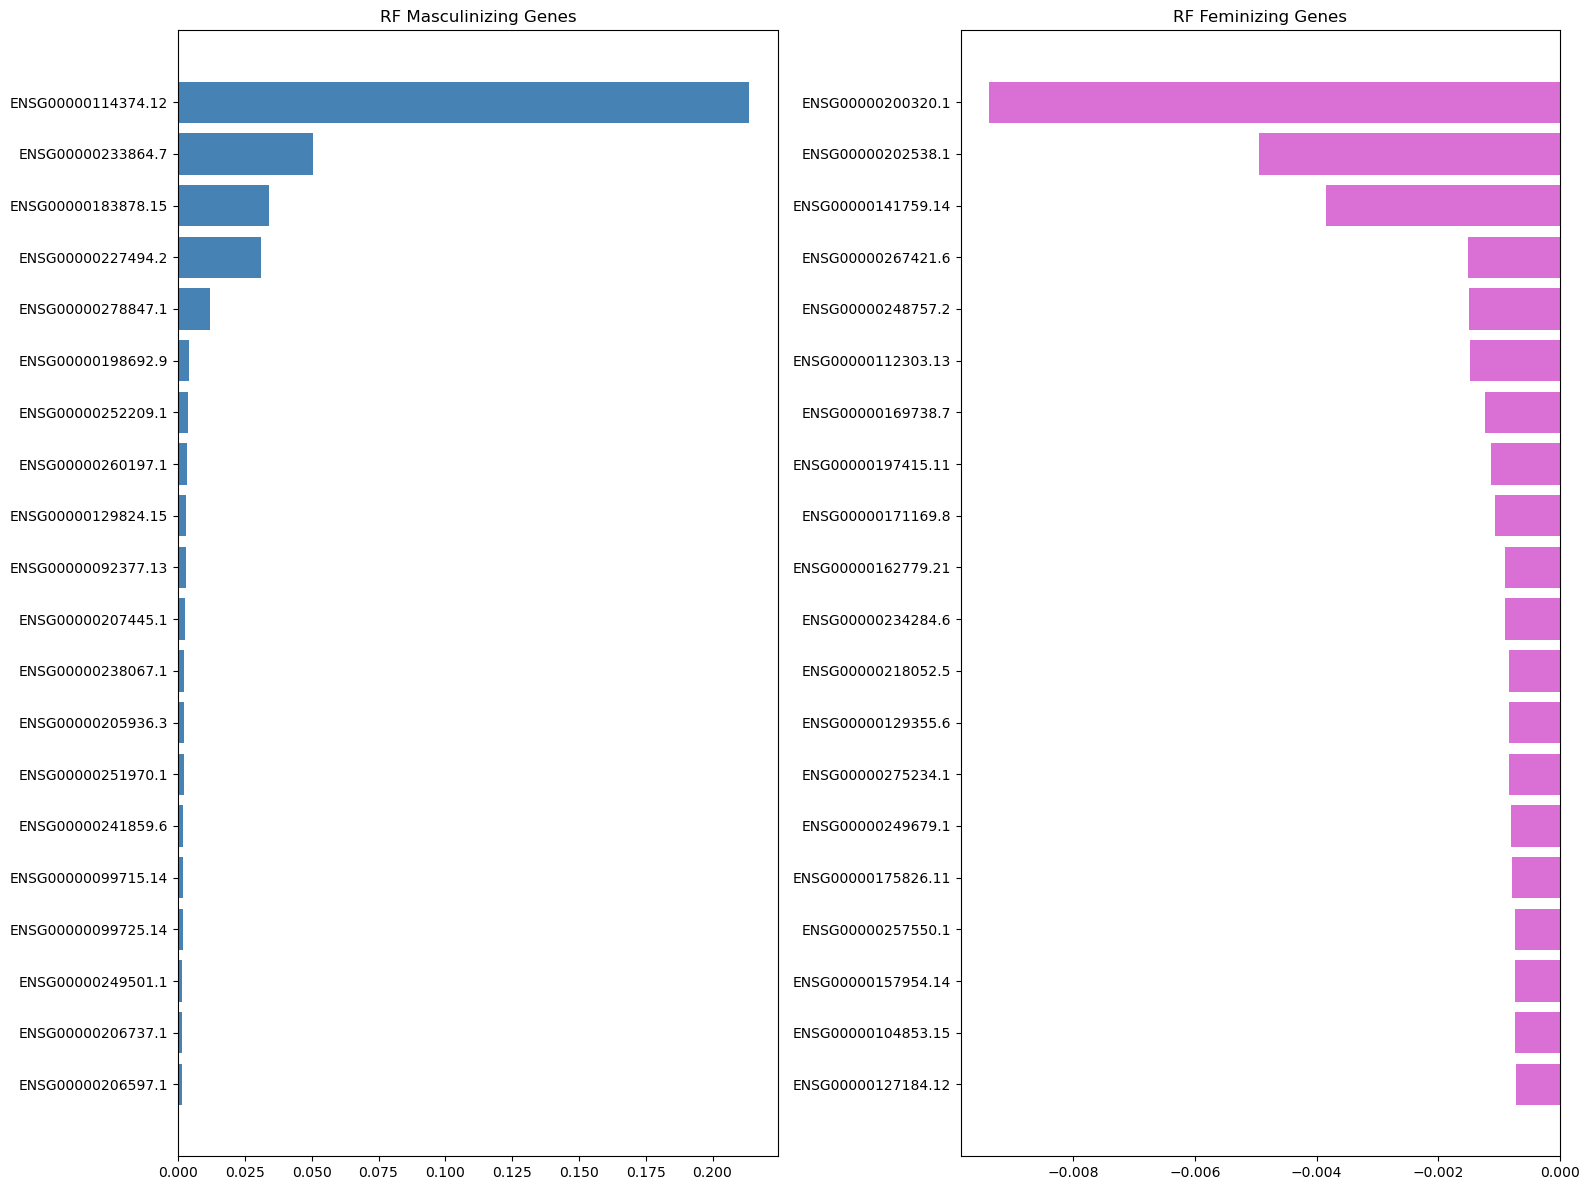

In [15]:
import matplotlib.pyplot as plt

top_masc_30 = top_masc.head(30)
top_fem_30  = top_fem.head(30)

masc_labels = top_masc_30["gene"].str.replace("^num__", "", regex=True)
fem_labels  = top_fem_30["gene"].str.replace("^num__", "", regex=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Masculinizing
axes[0].barh(np.arange(len(top_masc_30)),
             top_masc_30["difference_male_minus_female"],
             color="steelblue")
axes[0].set_yticks(np.arange(len(top_masc_30)))
axes[0].set_yticklabels(masc_labels)
axes[0].invert_yaxis()
axes[0].set_title("RF Masculinizing Genes")

# Feminizing
axes[1].barh(np.arange(len(top_fem_30)),
             top_fem_30["difference_male_minus_female"],
             color="orchid")
axes[1].set_yticks(np.arange(len(top_fem_30)))
axes[1].set_yticklabels(fem_labels)
axes[1].invert_yaxis()
axes[1].set_title("RF Feminizing Genes")

plt.tight_layout()
plt.show()


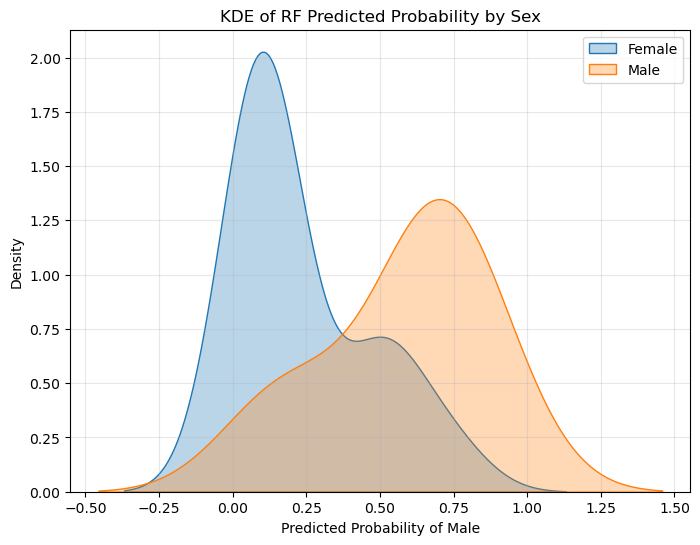

In [16]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.kdeplot(y_test_prob[y_test == 0], label="Female", fill=True, alpha=0.3)
sns.kdeplot(y_test_prob[y_test == 1], label="Male", fill=True, alpha=0.3)

plt.xlabel("Predicted Probability of Male")
plt.ylabel("Density")
plt.title("KDE of RF Predicted Probability by Sex")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# RANDOM-STATE ITERATION (MODEL UNCERTAINTY ANALYSIS)
seed_list = list(range(10))
results = []

X_full = df_full.drop(columns=["Sex", "Biosample accession"])
y_full = df_full["Sex"].map({"female": 0, "male": 1}).astype(int)

for seed in seed_list:

    X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(
        X_full, y_full, test_size=0.30, random_state=seed, stratify=y_full
    )

    X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(
        X_temp_s, y_temp_s, test_size=0.50, random_state=seed, stratify=y_temp_s
    )

    rf_seed_pipe = make_rf_pipeline()
    rf_seed_pipe.set_params(**rf_search.best_params_)
    rf_seed_pipe.set_params(model__random_state=seed)

    X_train_full_s = pd.concat([X_train_s, X_val_s])
    y_train_full_s = pd.concat([y_train_s, y_val_s])

    rf_seed_pipe.fit(X_train_full_s, y_train_full_s)

    y_prob_s = rf_seed_pipe.predict_proba(X_test_s)[:, 1]
    ap_s = average_precision_score(y_test_s, y_prob_s)

    results.append({"seed": seed, "test_pr_auc": ap_s})


rf_seed_df = pd.DataFrame(results)
print(rf_seed_df)

print("\nRF PR-AUC Uncertainty Across Splits:")
print("Mean:", rf_seed_df["test_pr_auc"].mean())
print("Std :", rf_seed_df["test_pr_auc"].std())
print("Min :", rf_seed_df["test_pr_auc"].min())
print("Max :", rf_seed_df["test_pr_auc"].max())


   seed  test_pr_auc
0     0     0.579167
1     1     0.642157
2     2     0.826923
3     3     0.525000
4     4     1.000000
5     5     0.942857
6     6     0.525000
7     7     0.839286
8     8     0.759524
9     9     0.440476

RF PR-AUC Uncertainty Across Splits:
Mean: 0.7080389463477699
Std : 0.19262385265200893
Min : 0.44047619047619047
Max : 1.0
